In [6]:
import torch
import matplotlib.pyplot as plt
import os
from neuralop.models import FNO
from torch.utils.data import DataLoader, Dataset
from neuralop.data.transforms.normalizers import UnitGaussianNormalizer

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on device: {device}")

Training on device: cuda


In [2]:
def load_data_from_paths(paths): # <-- Removed data_key
    all_tensors = []
    for p in paths:
        try:
            # Load the .pt file directly as a tensor
            tensor_data = torch.load(p).float() # <-- Changed loading function
            all_tensors.append(tensor_data)
        except Exception as e:
            print(f"Warning: Error loading {p}: {e}")
    # Concatenate all runs along the time dimension (dim=0)
    return torch.cat(all_tensors, dim=0)

# Loading test paths to ensure the test files are the same as in the training script
with open('test_paths.txt', 'r') as f:
    test_paths = [line.strip() for line in f]

# --- 2. Load Test Data ---
print("Loading test data...")
test_data_sequence = load_data_from_paths(test_paths)

Loading test data...


In [3]:
# --- 4. Fit and Transform (CORRECTED) ---
# --- A. Split the data ---
velocity_test_seq = test_data_sequence[:, 0:3, :, :, :]
force_test_seq = test_data_sequence[:, 3, 0, 0, 0]

# --- B. Create TWO normalizers ---
velocity_normalizer = UnitGaussianNormalizer(dim=[0, 2, 3, 4]) 
force_normalizer = UnitGaussianNormalizer(dim=[0]) 

print("Fitting the normalizers.")
velocity_normalizer.fit(velocity_test_seq)
force_normalizer.fit(force_test_seq)

print("Normalizing the data.")
velocity_test_seq = velocity_normalizer.transform(velocity_test_seq)
force_test_seq = force_normalizer.transform(force_test_seq)
print("Normalization complete.")

spatial_dims = velocity_test_seq.shape[2:]
force_test_seq = force_test_seq.view(-1, 1, 1, 1, 1).expand(-1, -1, *spatial_dims)

test_data = torch.cat([velocity_test_seq, force_test_seq], dim=1)

# --- FINAL SANITY CHECK ---
print(f"Normalized test data mean: {test_data.mean():.4f}") # Should be ~0.0
print(f"Normalized test data std: {test_data.std():.4f}")  # Should be ~1.0

print("Clearing RAM")
del test_data_sequence
del velocity_test_seq
del force_test_seq

Fitting the normalizers.
Normalizing the data.
Normalization complete.
Normalized test data mean: -0.0000
Normalized test data std: 1.0000
Clearing RAM


In [4]:
# --- 5. Define Simple Dataset Class ---
class TimeSteppingDataset(Dataset):
    """
    A simple dataset that just returns the (t, t+1) pairs
    from a pre-normalized data sequence.
    
    This version is "run-aware" to prevent mixing
    data from different simulation runs.
    """
    def __init__(self, data_sequence, steps_per_run):
        """
        Args:
            data_sequence (torch.Tensor): The giant tensor of all runs
            steps_per_run (int): The number of time steps in EACH run
                                 (e.g., 100)
        """
        self.data = data_sequence
        self.steps_per_run = steps_per_run
        
        # We can't use the last step of *any* run as an input 'x'
        self.valid_pairs_per_run = self.steps_per_run - 1
        
        # Calculate how many runs are in this tensor
        self.num_runs = self.data.shape[0] // self.steps_per_run
        
        if self.data.shape[0] % self.steps_per_run != 0:
            print(f"Warning: Data shape {self.data.shape[0]} is not "
                  f"perfectly divisible by steps_per_run {self.steps_per_run}")

    def __len__(self):
        """
        Returns the total number of *valid* (t, t+1) pairs.
        """
        return self.num_runs * self.valid_pairs_per_run

    def __getitem__(self, idx):
        """
        Gets the N-th *valid* pair, skipping boundaries.
        'idx' will be from 0 to (total_valid_pairs - 1)
        """
        
        # 1. Which run is this pair in?
        # e.g., if valid_pairs_per_run=99, idx=100 -> run_index=1
        run_index = idx // self.valid_pairs_per_run
        
        # 2. What is the time-index *within* that run?
        # e.g., if valid_pairs_per_run=99, idx=100 -> time_index=1
        time_index_in_run = idx % self.valid_pairs_per_run
        
        # 3. What is the *actual* index in the giant data tensor?
        # This calculation skips the boundary indices.
        # e.g., run_index=1, time_index=1 -> (1 * 100) + 1 = 101
        global_start_idx = (run_index * self.steps_per_run) + time_index_in_run
        
        # This will now correctly get (e.g.) data[101] and data[102]
        # and will *never* ask for (data[99], data[100])
        x = self.data[global_start_idx]
        y = self.data[global_start_idx + 1]
        
        return {'x': x, 'y': y[:3]}

In [5]:
# --- 6. Create Datasets and DataLoaders ---

# You must know this value from your data generation
# For example, if each .pt file had 100 time steps:
STEPS_PER_RUN = 41 

# Create the datasets from your NEW normalized tensors
test_dataset = TimeSteppingDataset(test_data, steps_per_run=STEPS_PER_RUN)

# Create the DataLoaders
# Try a small batch size first due to memory
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [13]:
model_imported = FNO(
    n_modes=(10, 10, 10),
    hidden_channels=64,
    in_channels=4,
    out_channels=3,
    n_layers=3
).to(device)

checkpoint_path = './best_model.pt'
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
model_imported.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

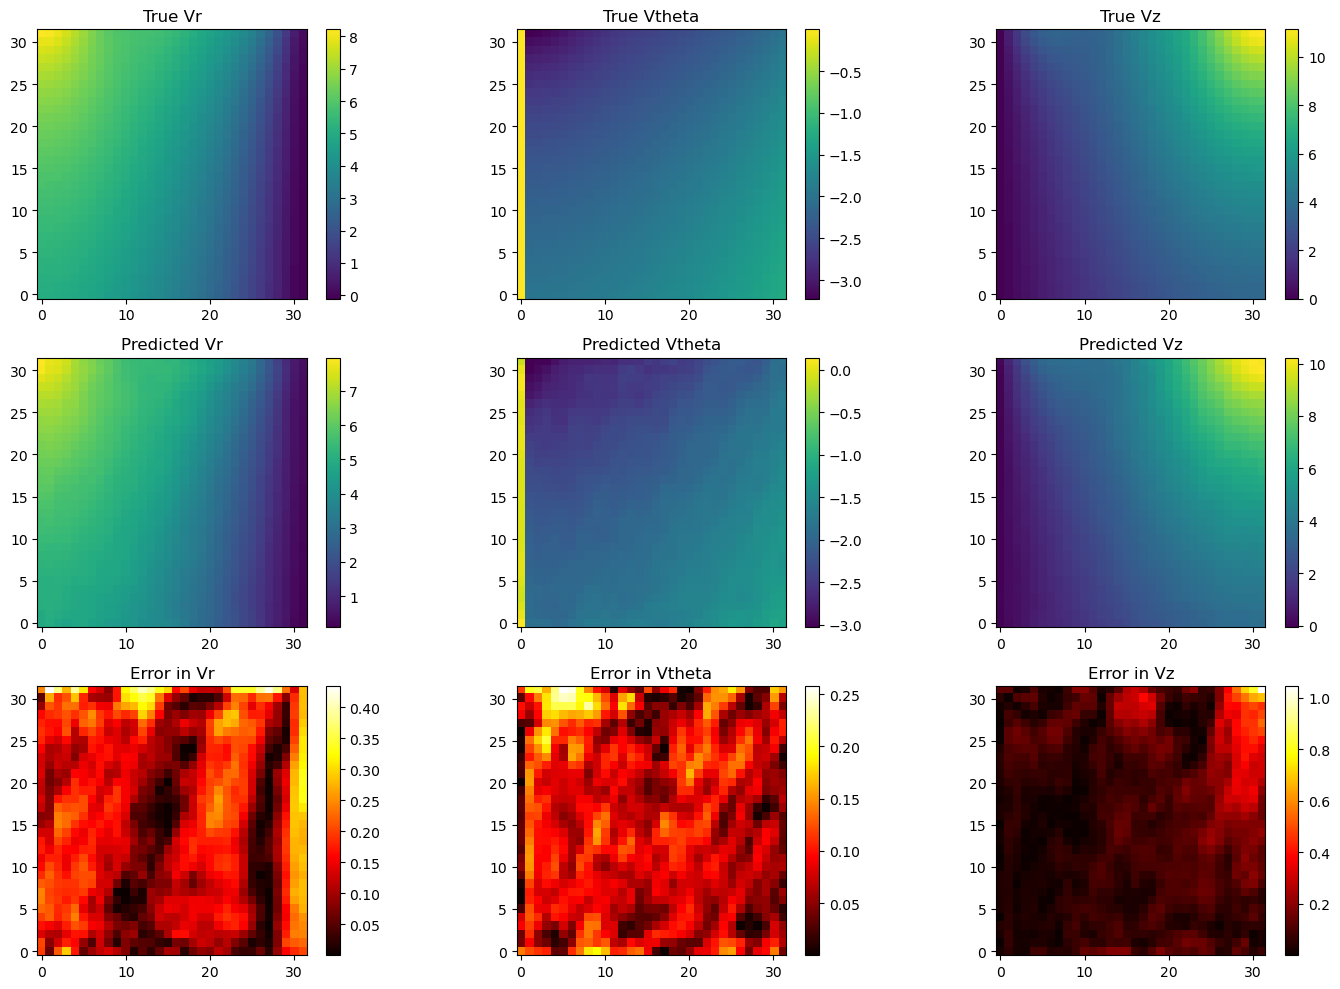

In [14]:
# Get one batch from the test loader
for batch in test_loader:
    x = batch['x'].to(device)         # Input tensor
    y = batch['y'].to(device)         # Target tensor
    break  # Only take the first batch

x_sample = x[20].unsqueeze(0)  # shape: [1, 4, X, Y, Z]
y_sample = y[20].unsqueeze(0)  # shape: [1, 3, X, Y, Z]

model_imported.eval()
with torch.no_grad():
    y_pred = model_imported(x_sample)

z_index = 10
true_slice = y_sample[0, :, :, :, z_index].cpu()
pred_slice = y_pred[0, :, :, :, z_index].cpu()
error_slice = torch.abs(true_slice - pred_slice)

fig, axs = plt.subplots(3, 3, figsize=(15, 10))
components = ['Vr', 'Vtheta', 'Vz']

for i in range(3):
    # True field
    im0 = axs[0, i].imshow(true_slice[i], cmap='viridis', origin='lower')
    axs[0, i].set_title(f"True {components[i]}")
    plt.colorbar(im0, ax=axs[0, i], fraction=0.046, pad=0.04)

    # Predicted field
    im1 = axs[1, i].imshow(pred_slice[i], cmap='viridis', origin='lower')
    axs[1, i].set_title(f"Predicted {components[i]}")
    plt.colorbar(im1, ax=axs[1, i], fraction=0.046, pad=0.04)

    # Error map
    im2 = axs[2, i].imshow(error_slice[i], cmap='hot', origin='lower')
    axs[2, i].set_title(f"Error in {components[i]}")
    plt.colorbar(im2, ax=axs[2, i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()